In [29]:
#Libraries
import sys
import pandas as pd
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss

In [30]:
versions = ( ("matplotlib", matplotlib.__version__),
            ("numpy", np.__version__),
            ("pandas", pd.__version__),
            ("seaborn", sns.__version__))

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

3.12.2 (tags/v3.12.2:6abddd9, Feb  6 2024, 21:26:36) [MSC v.1937 64 bit (AMD64)] 

library    version
------------------
matplotlib  3.7.5
numpy       1.26.4
pandas      2.2.3
seaborn     0.13.2


#### 1. Exploratory Data Analysis (EDA): 

In this section, I perform an exploratory data analysis to gain a better understanding of the day-ahead electricity price data. The goal is to explore the distribution, variability, and general patterns within the dataset.

Specifically, I will:

- Compute descriptive statistics (mean, median, min, max, standard deviation) of electricity prices.
- Examine how electricity prices vary throughout the day for each country.
- Compare price volatility between countries.

Insights from this stage will guide the further stages of my analysis

In [31]:
data = pd.read_csv("electricity_dah_prices.csv")
data.head()

,date,hour,france,italy,belgium,spain,uk,germany
0,2022/01/01,00:00 - 01:00,89.06,170.28,82.02,145.86,0.27,50.05
1,2022/01/01,01:00 - 02:00,78.48,155.72,67.07,114.90,-0.01,41.33
2,2022/01/01,02:00 - 03:00,85.16,147.09,75.11,113.87,0.27,43.22
3,2022/01/01,03:00 - 04:00,50.00,91.00,50.91,97.80,-0.01,45.46
4,2022/01/01,04:00 - 05:00,37.67,104.00,37.67,97.80,-0.01,37.67


In [32]:
data.shape

(8761, 8)

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8761 entries, 0 to 8760
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     8761 non-null   object 
 1   hour     8761 non-null   object 
 2   france   8760 non-null   float64
 3   italy    8760 non-null   float64
 4   belgium  8760 non-null   float64
 5   spain    8760 non-null   float64
 6   uk       7319 non-null   float64
 7   germany  8760 non-null   float64
dtypes: float64(6), object(2)
memory usage: 547.7+ KB


In [35]:
data.describe(include='object')

,date,hour
count,8761,8761
unique,365,24
top,2022/10/30,02:00 - 03:00
freq,25,366


In [36]:
#Combine date and hour into a single datetime column
data['hour'] = data['hour'].astype(str).str[:5]
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['hour'], format='%Y/%m/%d %H:%M')

data.drop(columns=['date', 'hour'], inplace=True)
data.set_index('datetime', inplace=True)

In [ ]:
data.isnull().sum()

france        1
italy         1
belgium       1
spain         1
uk         1442
germany       1
dtype: int64

C:\Users\larbi\AppData\Local\Temp\ipykernel_9184\1487904071.py:3: FutureWarning: DataFrame.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df2 = data.interpolate(method='pad')


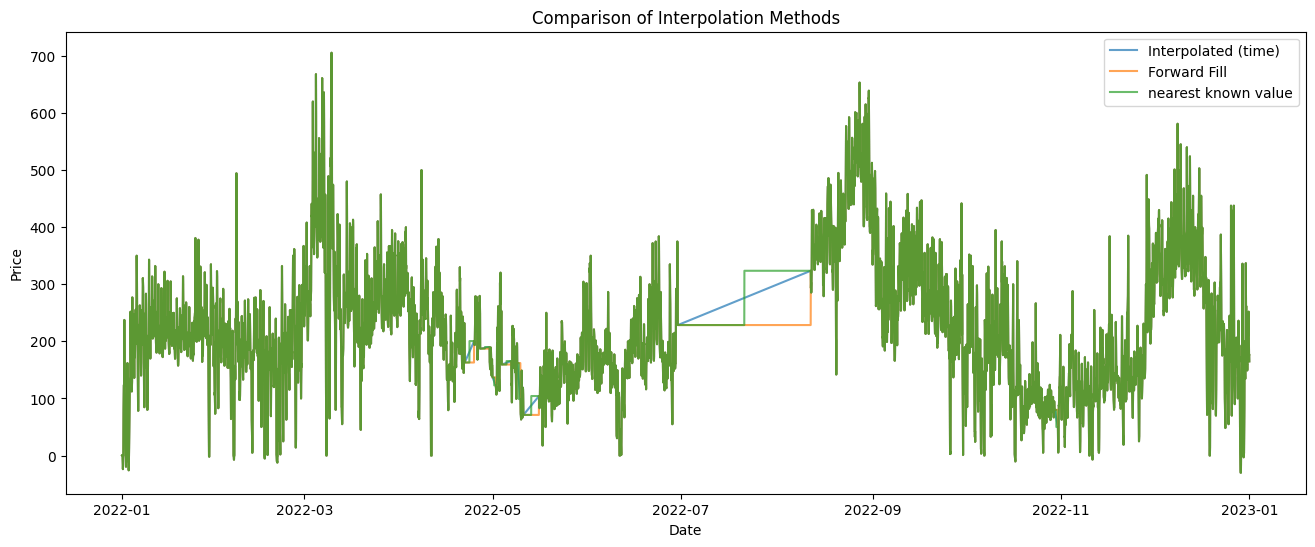

In [49]:
#Interpolate missing values
df1 = data.interpolate(method='time')
df2 = data.interpolate(method='pad')
df3 = data.interpolate(method='nearest')


plt.figure(figsize=(16, 6))
plt.plot(df1['uk'], label='Interpolated (time)', alpha=0.7)
plt.plot(df2['uk'], label='Forward Fill', alpha=0.7)
plt.plot(df3['uk'], label='nearest known value', alpha=0.7)

plt.title('Comparison of Interpolation Methods')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [52]:
# Interpolate missing values using time method
data = data.interpolate(method='time')
data.head()

,france,italy,belgium,spain,uk,germany
datetime,,,,,,
2022-01-01 00:00:00,89.06,170.28,82.02,145.86,0.27,50.05
2022-01-01 01:00:00,78.48,155.72,67.07,114.90,-0.01,41.33
2022-01-01 02:00:00,85.16,147.09,75.11,113.87,0.27,43.22
2022-01-01 03:00:00,50.00,91.00,50.91,97.80,-0.01,45.46
2022-01-01 04:00:00,37.67,104.00,37.67,97.80,-0.01,37.67


<Figure size 1600x600 with 0 Axes>

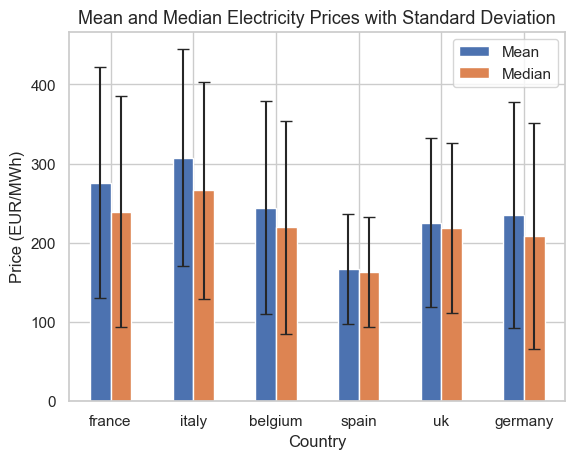

In [66]:
stats_summary = data.describe().T
stats_summary['mean'] = data.mean() 
stats_summary['median'] = data.median()
stats_summary['std'] = data.std()

# Visualization of basic descriptive statistics
plt.figure(figsize=(16, 6))
stats_summary[['mean', 'median']].plot(kind='bar', yerr=stats_summary['std'], capsize=4)
plt.title('Mean and Median Electricity Prices with Standard Deviation', size="13")
plt.xlabel('Country')
plt.ylabel('Price (EUR/MWh)')
plt.xticks(rotation=0)
plt.legend(['Mean', 'Median'])
plt.show()

**Interpretation:**

This bar chart compares the mean and median electricity prices (EUR/MWh) for France, Italy, Belgium, Spain, UK, and Germany with std as error bars. Italy has the highest mean and median prices, suggesting higher electricity costs. Spain has the lowest and most stable average prices with relatively small variability, indicating consistent market pricing. While, Belguim, Germany and France have similar volatility, France shows a noticeable difference between mean and median, indicating potential outliers or skewness due to extreme price spikes.

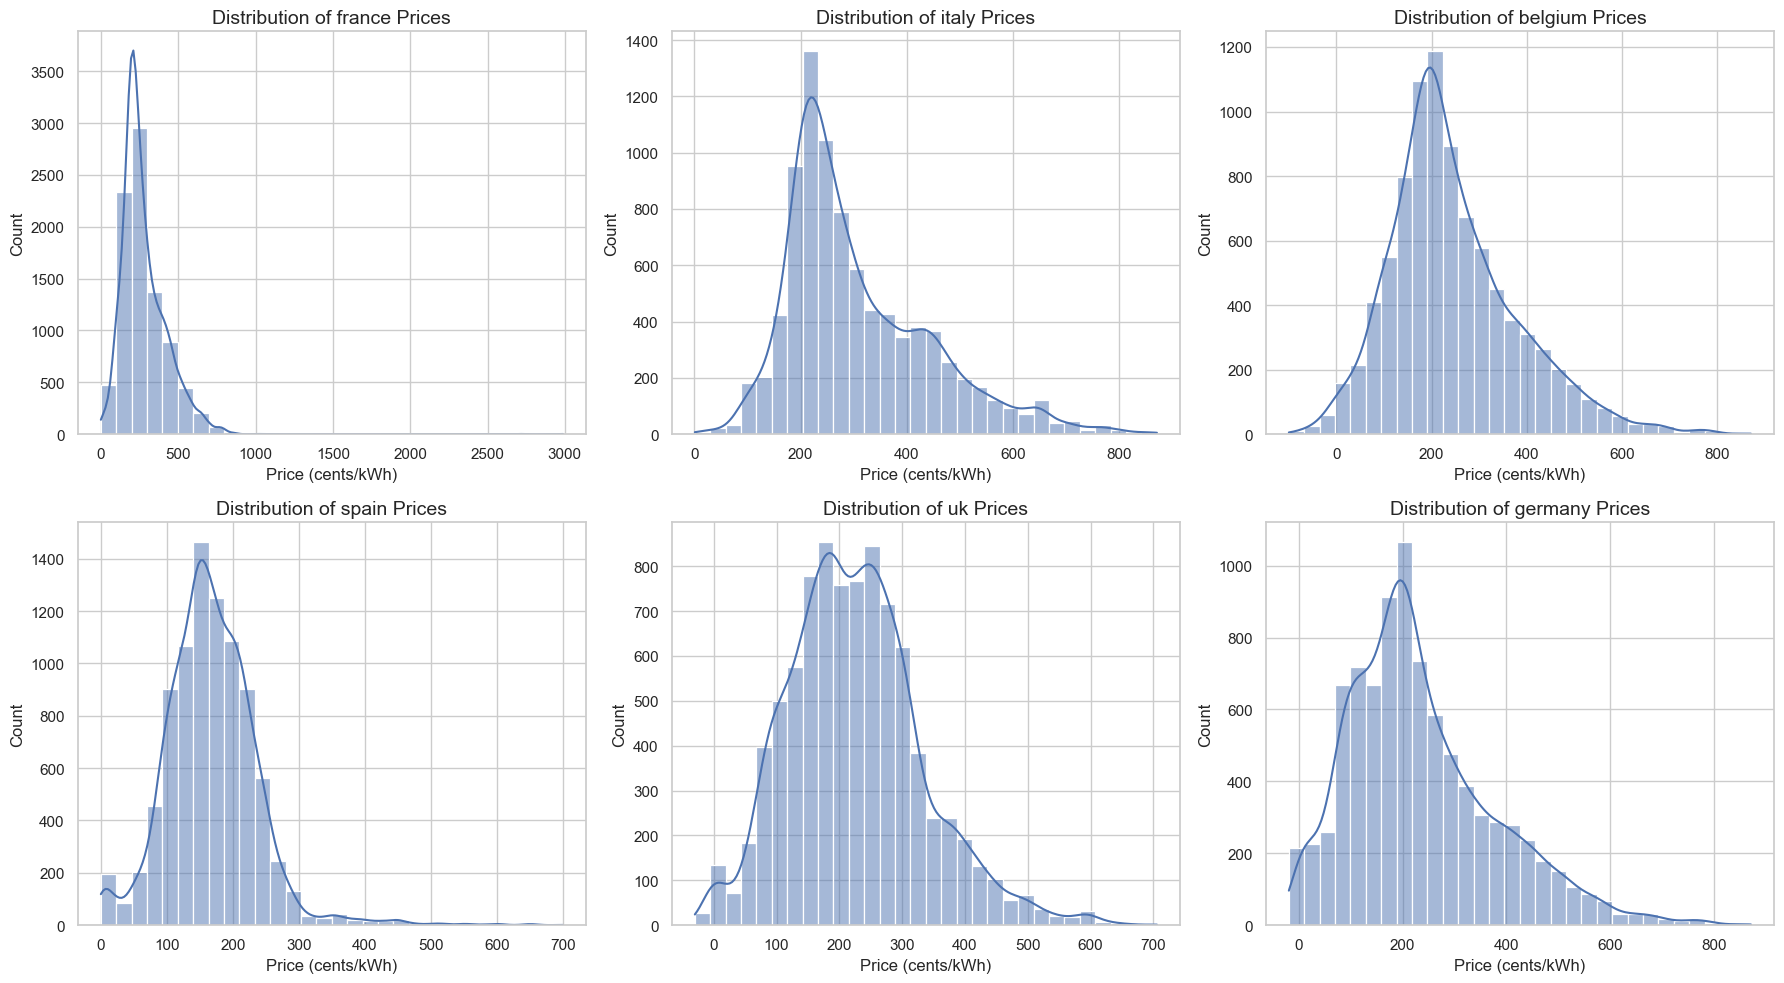

In [ ]:
#Price distribution visualization by country
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, x in enumerate(data.columns):
    sns.histplot(data[x], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {x} Prices', size=14)
    axes[i].set_xlabel('Price (cents/kWh)')
    axes[i].set_ylabel('Count')

# Hide any unused subplots if there are less than 6 columns
for j in range(len(data.columns), 6):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Interpretation:**

This charts compares the disrtibution of electricity prices, which can be useful for quickly spotting differences in market behavior, risk, and the presence of outliers across countries. 

In [ ]:
#Average price per country